In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from abc import abstractmethod
import scipy as sc
from ydata_profiling import ProfileReport
from scipy import stats as sts
import sklearn 
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, fbeta_score, precision_recall_curve, average_precision_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import phik
from typing import Literal
import optuna
from sklearn.pipeline import Pipeline

pd.options.display.max_columns = None
sklearn.set_config(transform_output='pandas')
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


# Features description:

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS

alpha = Right Ascension angle (at J2000 epoch)

delta = Declination angle (at J2000 epoch)

u = Ultraviolet filter in the photometric system

g = Green filter in the photometric system

r = Red filter in the photometric system

i = Near Infrared filter in the photometric system

z = Infrared filter in the photometric system

run_ID = Run Number used to identify the specific scan

rereun_ID = Rerun Number to specify how the image was processed

cam_col = Camera column to identify the scanline within the run

field_ID = Field number to identify each field

spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the 
output class)

class = object class (galaxy, star or quasar object)

redshift = redshift value based on the increase in wavelength

plate = plate ID, identifies each plate in SDSS

MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [3]:
df = pd.read_csv('data/weatherAUS.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
df = df.dropna(subset='RainTomorrow')


In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [7]:
df[df.isna().any()[df.isna().any() == True].index]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No
145455,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No
145456,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No
145457,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No


In [8]:
# profile = ProfileReport(df)
# profile.to_file('report.html')

In [9]:
df = df.drop(index=42358)

In [10]:
df.dropna().describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000


In [11]:
df.select_dtypes(include=['object']).isna().any()

Date            False
Location        False
WindGustDir      True
WindDir9am       True
WindDir3pm       True
RainToday        True
RainTomorrow    False
dtype: bool

In [12]:
df.select_dtypes(include=['object']) 

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,E,ESE,E,No,No
145455,2017-06-21,Uluru,E,SE,ENE,No,No
145456,2017-06-22,Uluru,NNW,SE,N,No,No
145457,2017-06-23,Uluru,N,SE,WNW,No,No


In [13]:
df['WindGustDir'].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', nan, 'E', 'SSW'], dtype=object)

In [14]:
def convert__wind_direction(x):
    if x == 'N':
        x = 0
    elif x  == 'NNE':
        x = 22.5
    elif x == 'NE':
        x = 45
    elif x == 'ENE':
        x = 77.5
    elif x  == 'E':
        x = 90
    elif x == 'ESE':
        x = 112.5
    elif x == 'SE':
        x = 135
    elif x  == 'SSE':
        x = 157.5
    elif x == 'S':
        x = 180
    elif x == 'SSW':
        x = 202.5
    elif x  == 'SW':
        x = 225
    elif x == 'WSW':
        x = 247.5
    elif x == 'W':
        x = 270
    elif x  == 'WNW':
        x = 292.5
    elif x == 'NW':
        x = 315
    elif x == 'NNW':
        x = 337.5
    else:
        x
    return x

def convert_binary(x):
    if x == 'Yes':
        x = 1
    elif x == 'No':
        x = 0
    else:
        return np.nan
    return x

In [15]:
df[['WindGustDir', 'WindDir9am', 'WindDir3pm']] = df[['WindGustDir', 'WindDir9am', 'WindDir3pm']].map(convert__wind_direction)

In [16]:
df[['RainToday', 'RainTomorrow']] = df[['RainToday', 'RainTomorrow']].map(convert_binary)

In [17]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,270.0,44.0,270.0,292.5,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,292.5,44.0,337.5,247.5,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,247.5,46.0,270.0,247.5,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,24.0,135.0,90.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,270.0,41.0,77.5,315.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,90.0,31.0,112.5,90.0,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,0.0,0
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,90.0,31.0,135.0,77.5,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,0.0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,337.5,22.0,135.0,0.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,0.0,37.0,135.0,292.5,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0


In [18]:
df.select_dtypes(include=['object']) 

,Date,Location
0,2008-12-01,Albury
1,2008-12-02,Albury
2,2008-12-03,Albury
3,2008-12-04,Albury
4,2008-12-05,Albury
...,...,...
145454,2017-06-20,Uluru
145455,2017-06-21,Uluru
145456,2017-06-22,Uluru
145457,2017-06-23,Uluru


In [19]:
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
df["days_since_start"] = (df["Date"] - df["Date"].min()).dt.days
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,days_since_start
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,270.0,44.0,270.0,292.5,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0,396
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,292.5,44.0,337.5,247.5,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0,397
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,247.5,46.0,270.0,247.5,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0,398
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,24.0,135.0,90.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0,399
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,270.0,41.0,77.5,315.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,90.0,31.0,112.5,90.0,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,0.0,0,3519
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,90.0,31.0,135.0,77.5,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,0.0,0,3520
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,337.5,22.0,135.0,0.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0,3521
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,0.0,37.0,135.0,292.5,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0,3522


In [21]:
df['current_month'] = df["Date"].dt.month
df['current_day'] = df['Date'].dt.day
df['current_year'] = df['Date'].dt.year
df['current_weekday'] = df['Date'].dt.weekday

interval columns not set, guessing: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'days_since_start', 'current_month', 'current_day', 'current_year', 'current_weekday']


/opt/anaconda3/envs/ClassificationParams/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Date is large: 3436. Are you sure this is not an interval variable? Analysis for pairs of variables including Date can be slow.
  warnings.warn(


<Axes: >

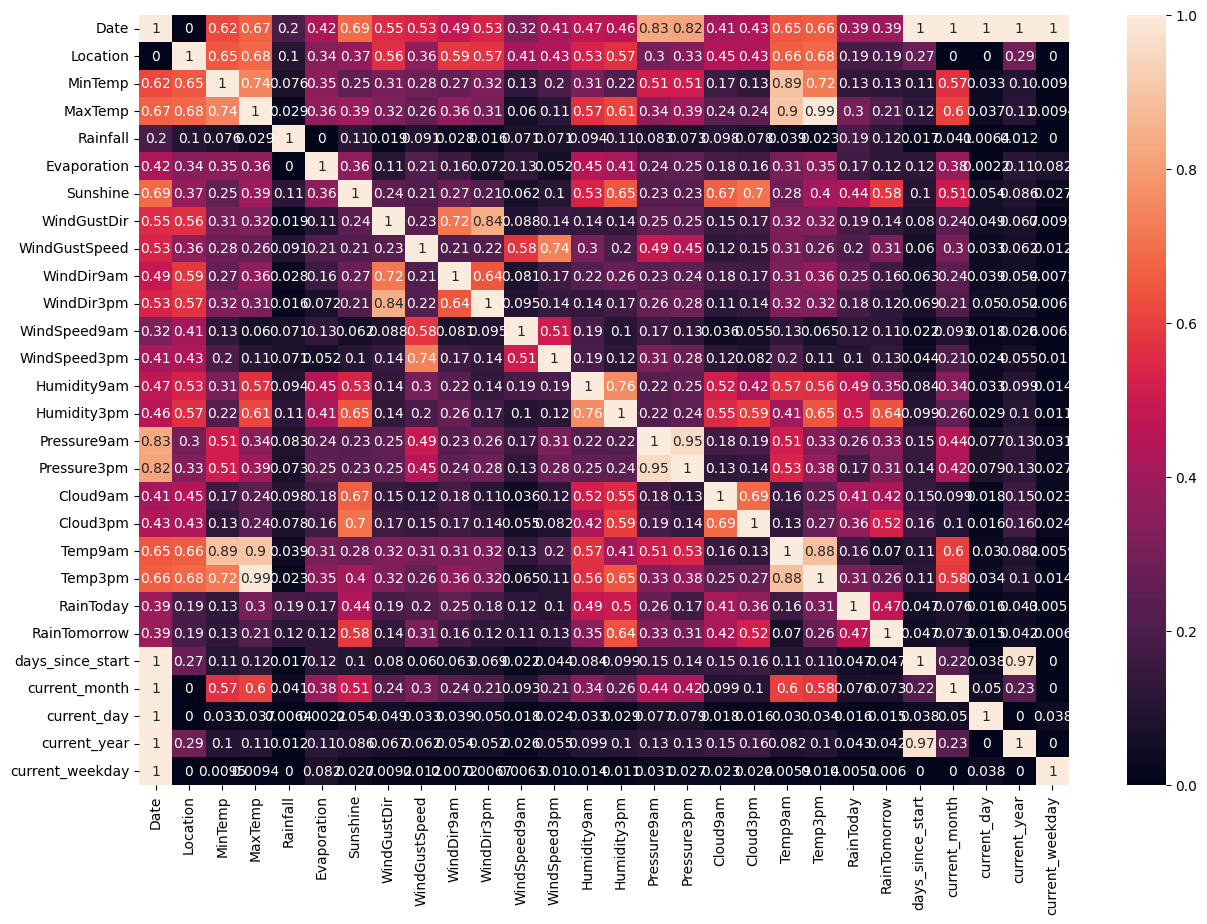

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.phik_matrix(), annot=True)

In [23]:
df = df.drop(columns='Date')

In [24]:
ode = OrdinalEncoder()
df['Location'] = ode.fit_transform(df[['Location']])
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,days_since_start,current_month,current_day,current_year,current_weekday
0,2.0,13.4,22.9,0.6,NaN,NaN,270.0,44.0,270.0,292.5,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0,396,12,1,2008,0
1,2.0,7.4,25.1,0.0,NaN,NaN,292.5,44.0,337.5,247.5,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0,397,12,2,2008,1
2,2.0,12.9,25.7,0.0,NaN,NaN,247.5,46.0,270.0,247.5,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0,398,12,3,2008,2
3,2.0,9.2,28.0,0.0,NaN,NaN,45.0,24.0,135.0,90.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0,399,12,4,2008,3
4,2.0,17.5,32.3,1.0,NaN,NaN,270.0,41.0,77.5,315.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0,400,12,5,2008,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,41.0,3.5,21.8,0.0,NaN,NaN,90.0,31.0,112.5,90.0,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,0.0,0,3519,6,20,2017,1
145455,41.0,2.8,23.4,0.0,NaN,NaN,90.0,31.0,135.0,77.5,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,0.0,0,3520,6,21,2017,2
145456,41.0,3.6,25.3,0.0,NaN,NaN,337.5,22.0,135.0,0.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0,3521,6,22,2017,3
145457,41.0,5.4,26.9,0.0,NaN,NaN,0.0,37.0,135.0,292.5,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0,3522,6,23,2017,4


In [25]:
# df = df.drop(index=145459)

In [26]:
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [27]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5)
X_train = knn.fit_transform(X_train)
X_test = knn.transform(X_test)

In [28]:
X_test

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,days_since_start,current_month,current_day,current_year,current_weekday
41305,45.0,13.7,31.4,0.0,10.60,11.52,90.0,41.0,22.5,77.5,19.0,24.0,46.0,34.0,1015.6,1011.9,2.4,2.2,24.3,31.0,0.0,2283.0,1.0,31.0,2014.0,4.0
141212,13.0,17.8,29.2,0.0,7.80,10.90,112.5,50.0,135.0,90.0,24.0,15.0,26.0,15.0,1017.9,1013.9,1.0,1.0,20.4,28.2,0.0,2433.0,6.0,30.0,2014.0,0.0
134243,17.0,4.5,18.7,0.0,2.44,5.92,337.5,26.0,45.0,337.5,4.0,13.0,89.0,60.0,1018.9,1015.4,5.0,4.8,9.6,17.3,0.0,1638.0,4.0,26.0,2012.0,3.0
8445,10.0,14.7,23.2,4.4,4.60,6.12,247.5,41.0,225.0,225.0,20.0,28.0,81.0,37.0,1014.9,1014.4,7.0,1.0,15.3,21.9,1.0,2912.0,10.0,22.0,2015.0,3.0
60222,6.0,7.6,25.6,0.0,10.16,12.52,180.0,46.0,180.0,157.5,17.0,22.0,56.0,19.0,1019.9,1018.3,1.8,2.6,15.4,24.6,0.0,2565.0,11.0,9.0,2014.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65180,19.0,4.3,17.7,0.0,5.80,12.20,180.0,28.0,247.5,180.0,13.0,13.0,58.0,37.0,1033.9,1032.7,1.0,0.0,11.5,17.0,0.0,1446.0,10.0,17.0,2011.0,0.0
130416,15.0,11.0,23.5,0.0,6.60,11.50,180.0,37.0,337.5,135.0,9.0,20.0,59.0,50.0,1019.9,1018.0,1.0,5.0,16.3,22.0,0.0,821.0,1.0,30.0,2010.0,5.0
46178,9.0,-1.3,13.8,0.2,1.40,7.70,315.0,31.0,225.0,315.0,2.0,15.0,88.0,47.0,1014.6,1011.4,5.0,3.0,2.9,13.5,0.0,591.0,6.0,14.0,2009.0,6.0
27945,34.0,20.9,27.6,9.8,3.80,4.48,112.5,24.0,121.5,292.5,0.0,2.0,85.0,69.0,1015.4,1014.0,6.0,6.6,22.4,26.7,1.0,1205.0,2.0,18.0,2011.0,4.0


In [29]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,days_since_start,current_month,current_day,current_year,current_weekday
113901,46.0,7.9,13.4,9.4,1.32,6.86,157.5,46.0,180.0,157.5,17.0,20.0,69.0,57.0,1027.40,1026.40,3.4,2.2,10.1,12.4,1.0,2806.0,7.0,8.0,2015.0,2.0
116964,29.0,7.2,17.3,0.0,3.14,6.30,270.0,61.0,0.0,247.5,17.0,33.0,80.0,72.0,1019.50,1016.50,7.0,6.0,13.9,16.7,0.0,2860.0,8.0,31.0,2015.0,0.0
17225,24.0,17.0,35.5,0.0,5.96,11.96,107.5,39.2,315.0,45.0,9.0,9.0,42.0,28.0,1008.86,1005.38,0.0,1.0,26.0,34.0,0.0,2634.0,1.0,17.0,2015.0,5.0
34573,38.0,18.8,21.8,9.0,2.20,6.60,184.5,45.8,202.5,180.0,30.0,28.0,82.0,75.0,1013.50,1014.80,8.0,3.0,19.5,21.2,1.0,1510.0,12.0,20.0,2011.0,1.0
106712,48.0,13.5,29.3,0.0,4.92,9.16,22.5,30.0,90.0,112.5,9.0,7.0,57.0,22.0,1021.40,1018.80,2.0,2.0,18.7,27.3,0.0,1607.0,3.0,26.0,2012.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66027,19.0,16.0,18.2,17.6,0.60,0.00,180.0,28.0,77.5,90.0,13.0,11.0,97.0,94.0,1013.50,1009.30,8.0,8.0,16.5,17.7,1.0,2352.0,4.0,10.0,2014.0,3.0
71786,20.0,17.8,38.2,0.0,8.20,7.50,315.0,35.0,0.0,270.0,15.0,15.0,23.0,11.0,1013.50,1010.30,7.0,3.0,25.6,35.9,0.0,1850.0,11.0,24.0,2012.0,5.0
7835,10.0,23.0,34.1,0.0,8.20,8.36,270.0,56.0,337.5,270.0,20.0,28.0,73.0,19.0,1002.10,999.20,7.0,1.0,25.6,33.3,0.0,2302.0,2.0,19.0,2014.0,2.0
6770,10.0,16.6,33.8,0.0,8.20,11.70,157.5,31.0,180.0,225.0,11.0,7.0,27.0,15.0,1016.60,1015.20,1.0,1.0,26.0,32.3,0.0,1148.0,12.0,23.0,2010.0,3.0


In [ ]:
k_range = range(1, 11)
inertia_values = []

# Обучаем KMeans с разным количеством кластеров и сохраняем inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cat_enc1)
    inertia_values.append(kmeans.inertia_)

# Построение локтевой диаграммы
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--', color='b')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia')
plt.title('Локтевая диаграмма для выбора лучшего k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [31]:
pt = PowerTransformer()
X_train = pd.DataFrame(pt.fit_transform(X_train), columns=X_train.columns)  
X_test = pd.DataFrame(pt.transform(X_test), columns=X_test.columns)

In [32]:
y_train.value_counts()

RainTomorrow
0    73911
1    21357
Name: count, dtype: int64

In [33]:
y_test.value_counts()

RainTomorrow
0    36404
1    10520
Name: count, dtype: int64

criterion : ('gini' or 'entropy', 'log_loss' , default= 'gini')
Split estimation function.
 
splitter  : ('random', ‘best’, default='best')
The way the algorithm, chooses a split: randomly or the one that is estimated as the best by the criterion function.
 
max_depth: (int, default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
 
min_samples_split: (int, float, default=None)
The minimum number of samples required to split a node.
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction of the total amount of samples and ceil(min_samples_split *n_samples) are the minimum number of samples for each split.
 
min_samples_leaf: (int, float, default=None)
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
 
min_weight_fraction_leaf: (0 < float < 0.5, default=0.0) 
The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
 
max_features: (int, float, sqrt, log2, default=None)
The number of features to consider when looking for the best split:
If int, then consider max_features features at each split.
If float, then max_features is a fraction and max(1, int(max_features *n_features_in_)) features are considered at each split.
If “sqrt”, then max_features=sqrt(n_features).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.
The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
 
random_state : (int, None, default=None)
Controls the randomness of the estimator.
 
max_leaf_nodes : (int, default=None)
The maximum amount of leaves in the tree, if None then the amount is unlimited.
 
min_impurity_decrease: (float, default=0.0)
A node will be split only if this split induces a decrease of the impurity greater than or equal to this value.
 
class_weight: (dict, list of dict ,  “balanced”, default=None)
Weights associated with classes in the form {class_label: weight}. If None, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].
 
ccp_alpha : (positive float, default=0.0)
Parameter for tree pruning (pruning). Used to optimize a tree by minimizing redundant splits, which helps avoid overfitting
 
monotonic_cst: (array like of int of shape(n_features), default = None)
Indicates the monotonicity constraint to enforce on each feature.
1: monotonic increase
0: no constraint
-1: monotonic decrease
If monotonic_cst is None, no constraints are applied.
multiclass classifications (i.e. when n_classes > 2),
multioutput classifications (i.e. when n_outputs_ > 1),
classifications trained on data with missing values.

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')

accuracy: 0.7851339527519686
f1: 0.7867336334462497


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')

accuracy: 0.7822862501065553
f1: 0.7838197075602954


In [ ]:
model = DecisionTreeClassifier(
    criterion='gini')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')

accuracy: 0.7850140652970761
f1: 0.7865828441846202


In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random'
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 

accuracy: 0.7880921628265489
f1: 0.7886960166416348


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='gini',
    splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 

accuracy: 0.7871755343527354
f1: 0.7884340259506352


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    min_weight_fraction_leaf=0.2,
    random_state=42,
    class_weight='balanced',
    min_impurity_decrease=0.025,
    max_leaf_nodes=100,
    ccp_alpha=0.1,)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 

accuracy: 0.22363651514520227
f1: 0.08174533905659964


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random',
    max_depth=15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 

accuracy: 0.8279238365068122
f1: 0.8179149508863629


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random',
    max_depth=5,
    min_samples_split=12,
    min_samples_leaf=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 

accuracy: 0.8106953876921795
f1: 0.8035496997548572


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    max_depth=5,
    min_samples_split=12,
    min_samples_leaf=5,
    max_features=77 # optimization
    )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
prob = model.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 
print(f'f-beta: {fbeta}')
print(f'confusion matrix:\n {cm}')

accuracy: 0.8355212684340636
f1: 0.8260004741677764
f-beta: 0.6353724430721729
confusion matrix:
 [[33938  2466]
 [ 5252  5268]]


In [ ]:
rfc = RandomForestClassifier(
    n_estimators=246,
    criterion='gini', 
    max_depth=9, 
    min_samples_split=13, 
    min_samples_leaf=8
)

rfc.fit(X_train, y_train)
y_pred = model.predict(X_test)
prob = model.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 
print(f'f-beta: {fbeta}')
print(f'confusion matrix:\n {cm}')

accuracy: 0.8355212684340636
f1: 0.8260004741677764
f-beta: 0.6353724430721729
confusion matrix:
 [[33938  2466]
 [ 5252  5268]]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])

roc = pd.DataFrame({'fpr': fpr, 
                    'tpr': tpr,
                    'thresholds': thresholds})
roc

,fpr,tpr,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.002091,0.976744
2,0.001373,0.067110,0.950000
3,0.004642,0.123764,0.860080
4,0.007527,0.185076,0.855328
5,0.010081,0.220722,0.794462
6,0.010686,0.227567,0.743169
7,0.010960,0.229658,0.722222
8,0.019339,0.295817,0.701870
9,0.030848,0.359696,0.622607


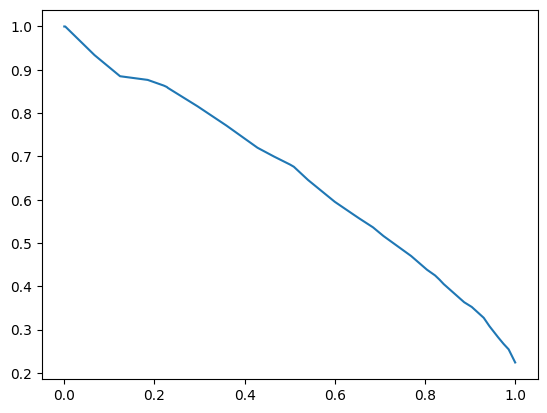

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, prob[:,1])

plt.plot(recall, precision)

Text(0, 0.5, 'tpr')

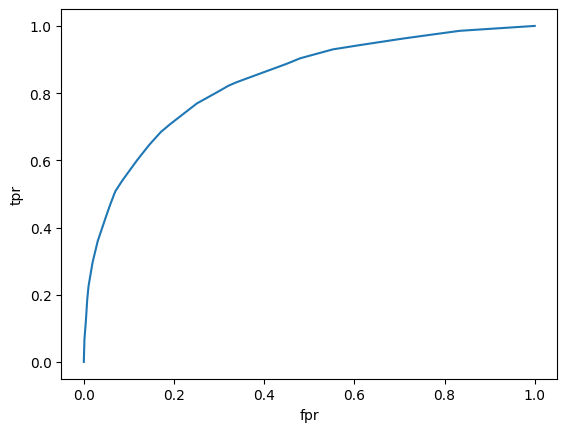

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')

Text(0, 0.5, 'tpr')

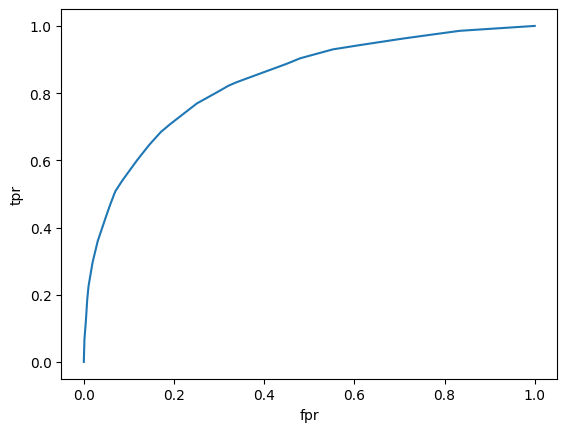

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])

roc = pd.DataFrame({'fpr': fpr, 
                    'tpr': tpr,
                    'thresholds': thresholds})
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')

In [ ]:
model = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='log2',
    min_weight_fraction_leaf=0.4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 

accuracy: 0.7763634848547977
f1: 0.6786226645107541


: 

In [ ]:
model = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='log2',
    min_weight_fraction_leaf=0.3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')

accuracy: 0.7763634848547977
f1: 0.6786226645107541


: 

In [ ]:
def random_optimization_classification(x_train, x_test, Y_train, Y_test, model: Literal['DecisionTree', 'RandomForest', 'XGBoost']):

    accuracy_scores = []
    f1_scores = []
    params_list = []
    fbetas = []
    count = 0
    
    if model == 'DecisionTree':

        for i in range(5):
            params = {
            'criterion': np.random.choice(['gini', 'entropy', 'log_loss']),
            'splitter': np.random.choice(['best', 'random']),
            'max_depth': np.random.randint(3, 50),  
            'min_samples_split': np.random.randint(2, 20),
            'min_samples_leaf': np.random.randint(1, 10),
            'min_weight_fraction_leaf': np.random.uniform(0.0, 0.5),
            'max_features': np.random.choice([None, 'sqrt', 'log2']),
            'random_state': 42,
            'max_leaf_nodes': np.random.choice([None] + list(np.random.randint(10, 300, size=10))),
            'min_impurity_decrease': np.random.uniform(0.0, 0.2),
            'class_weight': np.random.choice([None, 'balanced']),
            'ccp_alpha': np.random.uniform(0.0, 0.2)}
            
            i += 1
            
            model = DecisionTreeClassifier(**params)
            model.fit(x_train, Y_train)
            y_pred = model.predict(x_test)
            
            accuracy = accuracy_score(Y_test, y_pred)
            f1 = f1_score(Y_test, y_pred, average='weighted')
            fbeta = fbeta_score(Y_test, y_pred, beta=0.5)

            accuracy_scores.append(accuracy)
            f1_scores.append(f1)
            params_list.append(params)
            fbetas.append(fbeta)
            
    elif model == 'RandomForest':
        
        for i in range(5):
            params = {
            'n_estimators': np.random.randint(50, 200),
            'criterion': np.random.choice(['gini', 'entropy']),
            'max_depth': np.random.randint(3, 20),
            'min_samples_split': np.random.randint(2, 15),
            'min_samples_leaf': np.random.randint(1, 10),
            'max_features': np.random.choice([None, 'sqrt', 'log2']),
            'bootstrap': np.random.choice([True, False]),
            'oob_score': np.random.choice([True, False]),
            'random_state': 42,
            'class_weight': np.random.choice([None, 'balanced'])}
            if params['bootstrap']:
                params['max_samples'] = np.random.uniform(0.5, 1.0)
            else:
                params['max_samples'] = None
                params['oob_score'] = False 
                
            i += 1
            
            model = RandomForestClassifier(**params)
            model.fit(x_train, Y_train)
            y_pred = model.predict(x_test)
            
            accuracy = accuracy_score(Y_test, y_pred)
            f1 = f1_score(Y_test, y_pred, average='weighted')
            fbeta = fbeta_score(Y_test, y_pred, beta=0.5)

            accuracy_scores.append(accuracy)
            f1_scores.append(f1)
            params_list.append(params)
            fbetas.append(fbeta)
            
        
        
    elif model == 'XGBoost':
        for i in range(5):
            params = {
            'booster': np.random.choice(['gbtree', 'gblinear', 'dart']),
            'n_estimators': np.random.randint(50, 200),
            'max_depth': np.random.randint(3, 20),
            'learning_rate': np.random.uniform(0.01, 0.2),
            'subsample': np.random.uniform(0.5, 1.0),
            'colsample_bytree': np.random.uniform(0.5, 1.0),
            'colsample_bylevel': np.random.uniform(0.5, 1.0),
            'min_child_weight': np.random.randint(1, 10),
            'gamma': np.random.uniform(0, 0.1),
            'random_state': 42}
            
            dtrain = xgb.DMatrix(data=x_train, label=Y_train)
            dtest = xgb.DMatrix(data=x_test, label=Y_test)  
            model = xgb.XGBClassifier(**params)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            accuracy = accuracy_score(Y_test, y_pred)
            f1 = f1_score(Y_test, y_pred, average='weighted')
            fbeta = fbeta_score(Y_test, y_pred, beta=0.5)

            accuracy_scores.append(accuracy)
            f1_scores.append(f1)
            params_list.append(params)
            fbetas.append(fbeta)


    for i in range(len(params_list)):
        params_list[i] = list(params_list[i].values())
        
        for x in range(len(params_list[i])):
            if isinstance(params_list[i][x], float):
                params_list[i][x] = round(params_list[i][x], 2)
            params_list[i][x] = str(params_list[i][x])
            params_list[i][x] += '\n'
        params_list[i] = ''.join(params_list[i])
        
    listed = list(params.keys())
    for d in range(len(listed)):
        listed[d] += '\n'
        string = ''.join(listed)
    # График
    plt.figure(figsize=(18, 6))
    plt.plot(range(1, 6), f1_scores, marker='o', label='F1 Score')
    plt.plot(range(1, 6), fbetas, marker='s', label='F Beta Score')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title('Decision Tree Performance over 15 Runs')
    plt.plot([], [], label=f"Parameters:\n {string}")
    plt.legend(loc='lower left')
    plt.xticks(range(1, 6), params_list)
    plt.show()


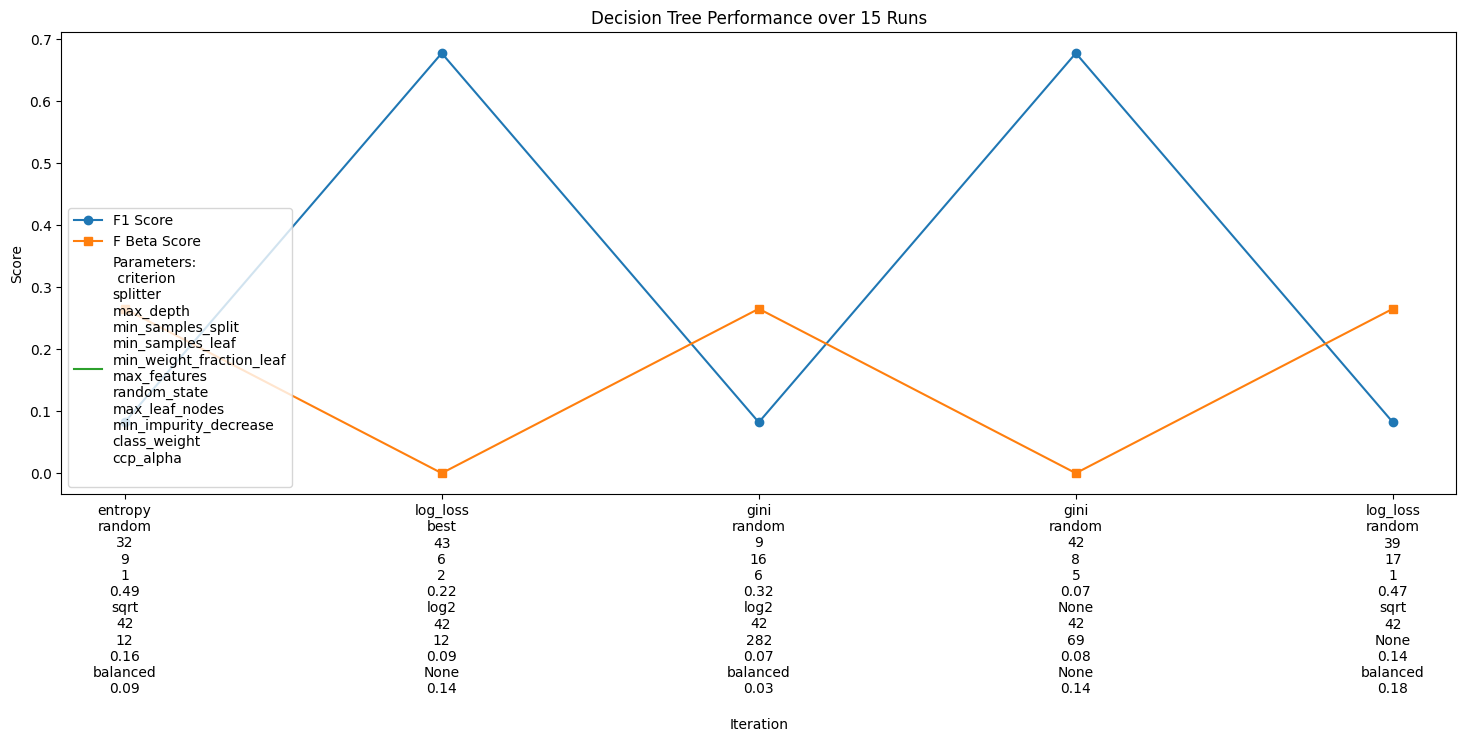

In [ ]:
random_optimization_classification(X_train, X_test, y_train, y_test, model='DecisionTree')

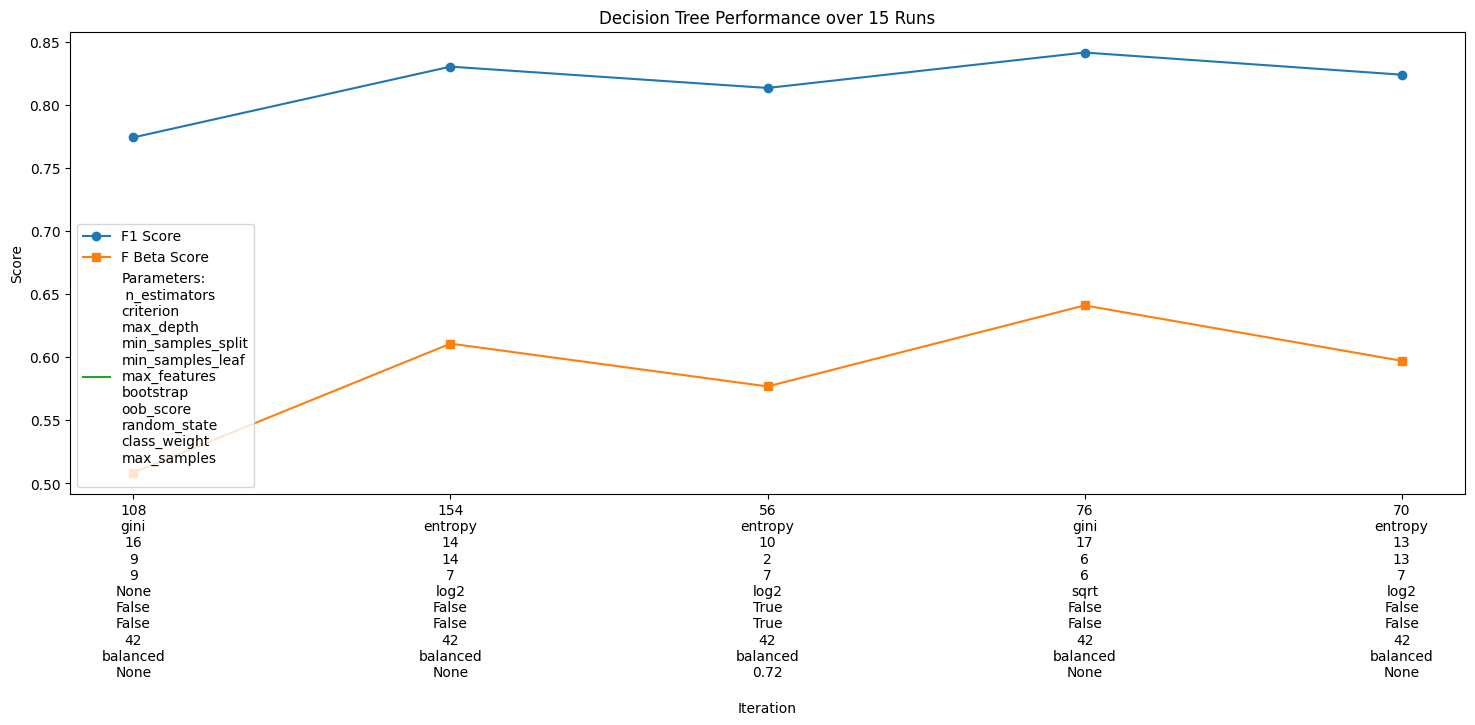

In [ ]:
random_optimization_classification(X_train, X_test, y_train, y_test, model='RandomForest')

/opt/anaconda3/envs/ClassificationParams/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:23:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bylevel", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


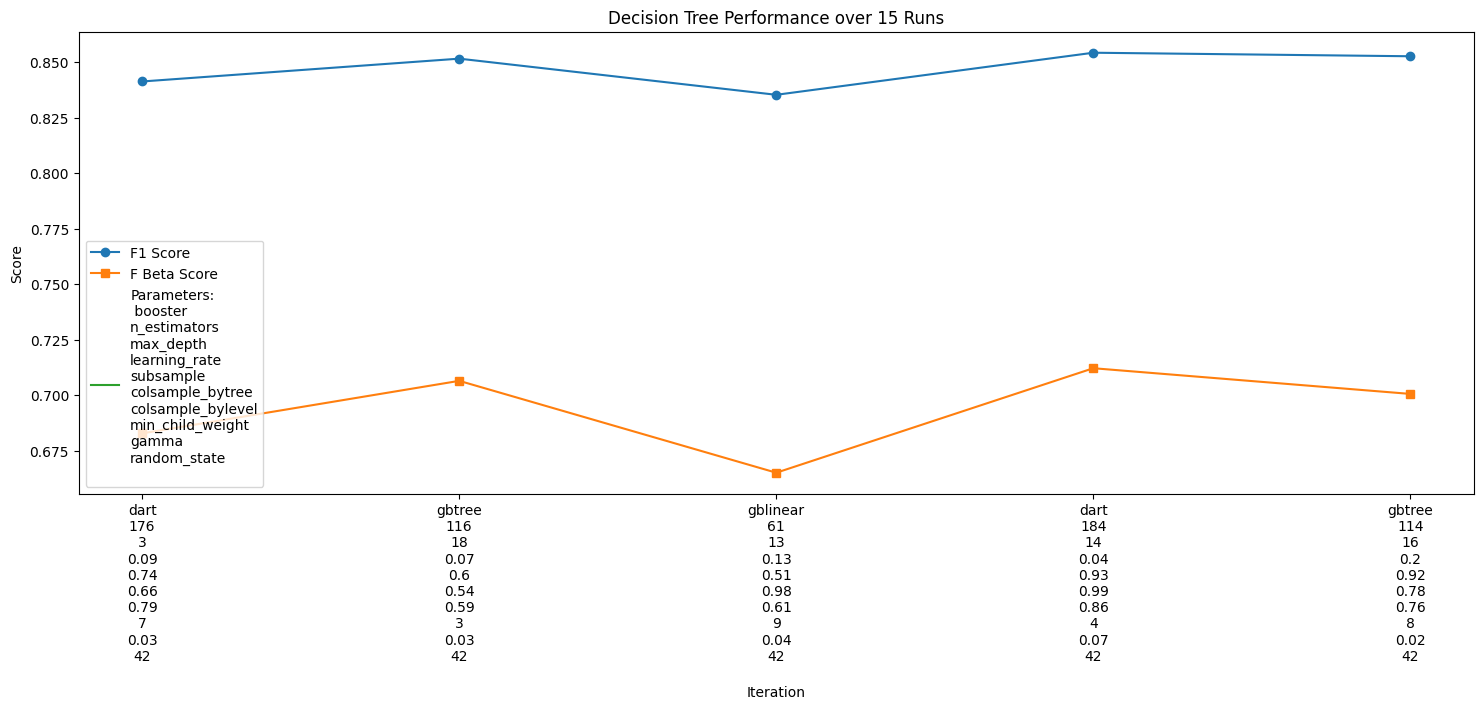

In [ ]:
random_optimization_classification(X_train, X_test, y_train, y_test, model='XGBoost')

In [ ]:
model = XGBClassifier()
y_pred = model.predict(X_test)
prob = model.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print(f'accuracy: {accuracy}')
print(f'f1: {f1}') 
print(f'f-beta: {fbeta}')
print(f'confusion matrix:\n {cm}')

In [ ]:
model = RandomForestClassifier(n_estimators=100, verbose=2, random_state=42)
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.4s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(random_state=42, verbose=2)

: 

max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf – restrictions on tree depth and minimum samples per leaf.
max_features – the number of features considered at each split.
random_state – controls randomness for reproducibility.
max_leaf_nodes, min_impurity_decrease, ccp_alpha – tree structure constraints.
class_weight – class weights (same as in DecisionTreeClassifier).
n_estimators – the number of trees in the forest (default is 100).
bootstrap – whether to use bootstrap sampling (default is True).
oob_score – whether to compute out-of-bag (OOB) estimates (default is False).
n_jobs – number of CPU threads to use (-1 uses all available cores).
warm_start – if True, trees are added to an already trained forest (default is False).
verbose – controls the amount of logging output.
max_samples – the fraction or number of samples randomly selected for each tree (default is None, meaning all samples are used).

In [45]:
from xgboost import XGBClassifier

In [55]:
def objective(trial):
    model_name = trial.suggest_categorical('model', ['XGBClassifier', 
                                                     'RandomForestClassifier',
                                                     'DecisionTreeClassifer'])
    
    if model_name == 'XGBClassifier':
        n_estimators = trial.suggest_int('n_estimators', 1, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.9)
        max_depth = trial.suggest_int('max_depth', 1, 30)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 1)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 1)
        model = XGBClassifier(n_estimators=n_estimators, 
                             learning_rate=learning_rate, 
                             max_depth=max_depth,
                             reg_alpha=reg_alpha,
                             reg_lambda=reg_lambda)
        
    elif model_name == 'RandomForestClassifier':
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        max_depth = trial.suggest_int('max_depth', 1, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
        min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.00001, 0.5)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 3, 200)
        n_estimators = trial.suggest_int('n_estimators', 2, 1000)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        model = RandomForestClassifier(criterion=criterion,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       max_features=max_features,
                                       max_leaf_nodes=max_leaf_nodes,
                                       n_estimators=n_estimators,
                                       bootstrap=bootstrap)
        
    else:
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        max_depth = trial.suggest_int('max_depth', 1, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
        min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 3, 200)
        splitter = trial.suggest_categorical('splitter', ['random', 'best'])
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        model = DecisionTreeClassifier(criterion=criterion,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       max_features=max_features,
                                       max_leaf_nodes=max_leaf_nodes,
                                       splitter=splitter,
                                       class_weight=class_weight,
                                       )
        
    pipeline = Pipeline([("classifier", model)])
    
    pipeline.fit(X_train, y_train)
        
    y_pred = pipeline.predict(X_test)
    
    fbeta = fbeta_score(y_test, y_pred, beta=0.5)
    
    return fbeta

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
print(study.best_params)
    

        

[I 2025-02-23 01:42:44,243] A new study created in memory with name: no-name-9336aca3-ae6b-44df-a5bf-b2e0c1911fed
[I 2025-02-23 01:42:44,479] Trial 0 finished with value: 0.45692337197408794 and parameters: {'model': 'DecisionTreeClassifer', 'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.1877943901060518, 'max_features': None, 'max_leaf_nodes': 57, 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.45692337197408794.
[I 2025-02-23 01:42:45,275] Trial 1 finished with value: 0.6980647709320695 and parameters: {'model': 'XGBClassifier', 'n_estimators': 93, 'learning_rate': 0.08886334378791437, 'max_depth': 7, 'reg_alpha': 0.9486380826079615, 'reg_lambda': 0.06162449133569308}. Best is trial 1 with value: 0.6980647709320695.
[I 2025-02-23 01:42:45,308] Trial 2 finished with value: 0.27891737891737894 and parameters: {'model': 'DecisionTreeClassifer', 'criterion': 'gini', 'max_depth': 8, 'min

{'model': 'XGBClassifier', 'n_estimators': 124, 'learning_rate': 0.11052642606128218, 'max_depth': 14, 'reg_alpha': 0.41427024114401095, 'reg_lambda': 0.6637442969699173}


In [58]:
study.best_value, study.best_params

(0.7109148112294289,
 {'model': 'XGBClassifier',
  'n_estimators': 124,
  'learning_rate': 0.11052642606128218,
  'max_depth': 14,
  'reg_alpha': 0.41427024114401095,
  'reg_lambda': 0.6637442969699173})